# CD4 Cropseq 1D effect size and WT coexpression analysis

- Hyperparameter check
- Select genes to check correlation against
- Save the preprocessed AnnData object

In [2]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [3]:
import functools

In [4]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [5]:
data_path = '/data_volume/memento/tfko140/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)

### Read the AnnData object

In [8]:
adata = sc.read(data_path + 'tfko.sng.guides.full.ct.h5ad')

Only considering the two last: ['.ct', '.h5ad'].
Only considering the two last: ['.ct', '.h5ad'].


### Pick out guides to test

In [9]:
counts = adata[adata.obs.WT == 'F'].obs.guide1_cov.value_counts()
filtered_guides = counts[counts > 500].index.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
wt_guides = adata[adata.obs.WT == 'T'].obs.guide1_cov.drop_duplicates().tolist()

In [11]:
filtered_guides = list(set(filtered_guides) - set(wt_guides))

In [12]:
len(filtered_guides)

145

### Setup memento

In [13]:
adata.obs['q'] = 0.15

In [14]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Read DE genes

In [82]:
de_genes = {}
all_de_genes = set([])
all_available_genes = set([])
for guide in filtered_guides:
    
    res = pd.read_csv(data_path + '1d_tests/{}.csv'.format(guide), index_col=0)
    res['de_fdr'] = memento.util._fdrcorrect(res['de_pval'])
    all_de_genes |= set(res.query('de_fdr < 0.01').sort_values('de_coef').head(50).index.tolist())
    if len(all_available_genes) == 0:
        all_available_genes = set(res.index)
    else:
        all_available_genes &= set(res.index)

In [83]:
de_genes_to_plot = list(all_de_genes & all_available_genes)

In [84]:
effect_size_heatmap = []
for guide in filtered_guides:
    res = pd.read_csv(data_path + '1d_tests/{}.csv'.format(guide), index_col=0)
    effect_size_heatmap.append(res.loc[de_genes_to_plot].de_coef.values)

In [85]:
effect_size_heatmap = pd.DataFrame(np.vstack(effect_size_heatmap), index=filtered_guides, columns=de_genes_to_plot)

In [86]:
effect_size_heatmap.shape

(145, 445)

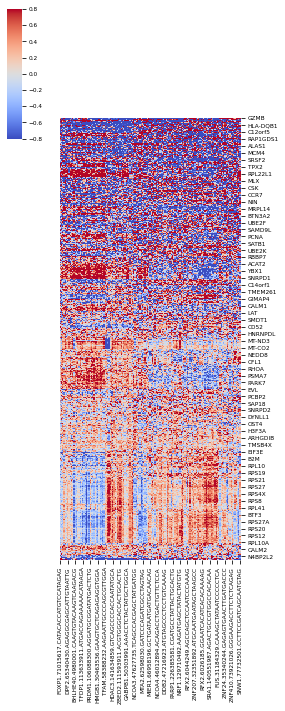

In [126]:
cg = sns.clustermap(effect_size_heatmap.T, center=0, cmap='coolwarm', vmax=0.8, vmin=-0.8, z_score=1, figsize=(4, 10))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

In [100]:
order = cg.dendrogram_row.reordered_ind
ordered_de_genes = list(np.array(de_genes_to_plot)[order])

In [112]:
guide_order = cg.dendrogram_col.reordered_ind
ordered_guides = list(np.array(filtered_guides)[guide_order])

In [119]:
effect_size_heatmap.head(2)

,GLIPR2,BRK1,SAP18,SEC61B,CD74,RPL18,EPM2AIP1,ATP6V0E1,ERGIC2,CDKN3,...,LCP1,NDUFA1,RPS3,CCND2,IL2RA,CLIC1,SLC25A6,RBX1,SUMO1,RPL4
BACH1.29326546.AACTGACAGAGTCCGTACTG,-0.095100,-0.128922,-0.172988,-0.160336,-0.155005,-0.084718,-0.107107,-0.101503,-0.077416,-0.209699,...,-0.150286,-0.053557,-0.093878,-0.188641,-0.180857,-0.149198,-0.129502,-0.164337,-0.123250,-0.087818
CTCFL.57518862.CAAGTGTAACGACTGCAACA,0.023008,-0.096903,-0.092570,-0.068638,-0.052267,-0.058600,-0.087874,-0.134649,-0.085130,-0.046606,...,-0.081209,-0.065264,-0.063754,-0.014038,-0.141629,-0.061679,-0.028808,-0.052386,-0.080214,-0.037437


<AxesSubplot:>

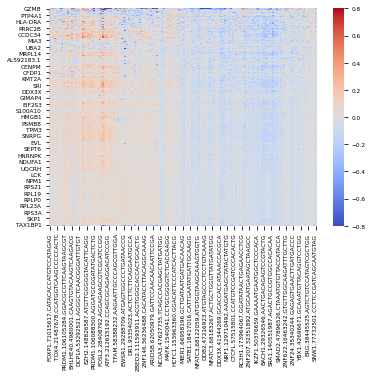

In [122]:
sns.heatmap(effect_size_heatmap.T.loc[ordered_de_genes, ordered_guides], center=0, cmap='coolwarm', vmax=0.8, vmin=-0.8,)

### WT coexpression

In [101]:
adata_wt = adata[adata.obs['WT'] == 'T'].copy().copy()

In [102]:
adata_wt.obs['group'] = 'A'

In [103]:
memento.create_groups(adata_wt, label_columns=['donor','well', 'group'])
memento.compute_1d_moments(adata_wt, gene_list=ordered_de_genes)

In [105]:
# filtered_regulators = list(set(ordered_de_genes) & set(adata_wt.var.index))
memento.compute_2d_moments(adata_wt, list(itertools.combinations(ordered_de_genes, 2)))
moments = memento.get_2d_moments(adata_wt, groupby='group')

In [107]:
gxg_matrix = pd.DataFrame(index=ordered_de_genes, columns=ordered_de_genes)
for idx, row in moments.iterrows():
    gxg_matrix.loc[row['gene_1'], row['gene_2']] = row['group_A']
    gxg_matrix.loc[row['gene_2'], row['gene_1']] = row['group_A']

<AxesSubplot:>

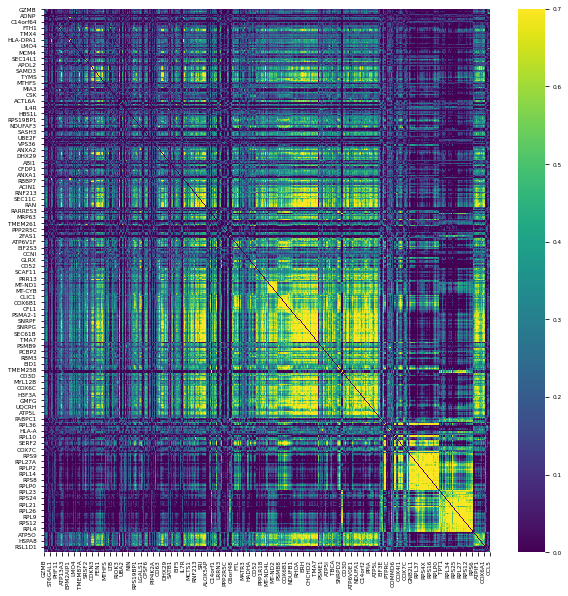

In [127]:
plt.figure(figsize=(10,10))
sns.heatmap(gxg_matrix.fillna(0), cmap='viridis', vmin=0, vmax=0.7)

In [58]:
de_pairs ={}
for g1, g2 in itertools.combinations(filtered_guides, 2):
    
    gene1, gene2 = g1.split('.')[0], g2.split('.')[0]
    shared = list(set(de_genes[g1]) & set(de_genes[g2]))
    if len(shared) > 10 and gene1 in results[g2].index and gene2 in results[g1].index:
        de_pairs[g1+'-'+g2] = shared

In [59]:
len(de_pairs)

55

In [66]:
k

'STAT1.190997935.CCTGATTAATGATGAACTAG-ELK4.205623693.CTTTACATAATAGTATCTGA'

In [67]:
'ELK4' in results['STAT1.190997935.CCTGATTAATGATGAACTAG'].index

True

In [ ]:
dc_results = {}
for k,v in de_pairs.items():
    
    guide1, guide2 = k.split('-')
    gene1, gene2 = guide1.split('.')[0], guide2.split('.')[0]
    
    # For g1 KO
    adata_ko = adata.copy()[
        adata.obs.guide1_cov.isin([guide1]) | \
        (adata.obs.WT=='T')].copy()
    ko_converter={'F':1, 'T':0}

    adata_ko.obs['ko_indicator'] = (adata_ko.obs['guide1_cov']==guide1).astype(int)

    memento.create_groups(adata_ko, label_columns=['ko_indicator', 'well'])
    memento.compute_1d_moments(adata_ko, min_perc_group=.7)
    
    if gene2 not in adata_ko.var.index:
        continue
    
    filtered_values = [gene for gene in v if gene in adata_ko.var.index]
    memento.compute_2d_moments(adata_ko, list(itertools.product([gene2], filtered_values)))

    meta_df = pd.get_dummies(memento.get_groups(adata_ko), drop_first=True)
    treatment = meta_df[['ko_indicator']]
    covariate = meta_df.iloc[:, 1:]

    memento.ht_2d_moments(
        adata_ko, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=5000, 
        verbose=1,
        num_cpus=len(filtered_values),
        resampling='bootstrap',
        resample_rep=False,
        approx=True)
    res_guide1 =  memento.get_2d_ht_result(adata_ko)
    
    # For g2 KO
    adata_ko = adata.copy()[
        adata.obs.guide1_cov.isin([guide2]) | \
        (adata.obs.WT=='T')].copy()
    ko_converter={'F':1, 'T':0}

    adata_ko.obs['ko_indicator'] = (adata_ko.obs['guide1_cov']==guide2).astype(int)

    memento.create_groups(adata_ko, label_columns=['ko_indicator', 'well'])
    memento.compute_1d_moments(adata_ko, min_perc_group=.7)
    if gene1 not in adata_ko.var.index:
        continue
    filtered_values = [gene for gene in v if gene in adata_ko.var.index]
    memento.compute_2d_moments(adata_ko, list(itertools.product([gene1], filtered_values)))

    meta_df = pd.get_dummies(memento.get_groups(adata_ko), drop_first=True)
    treatment = meta_df[['ko_indicator']]
    covariate = meta_df.iloc[:, 1:]

    memento.ht_2d_moments(
        adata_ko, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=5000, 
        verbose=1,
        num_cpus=len(filtered_values),
        resampling='bootstrap',
        resample_rep=False,
        approx=True)
    res_guide2 =  memento.get_2d_ht_result(adata_ko)
    
    res = res_guide1.merge(res_guide2, on=['gene_2'], suffixes=('_guide1', '_guide2'))
    
    dc_results[k] = res

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:    2.8s remaining:   12.6s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:    3.1s finished
[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:    0.7s remaining:    3.2s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:    1.1s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:    5.8s remaining:   37.8s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:    6.6s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:    1.7s remaining:   11.0s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:    2.2s finished
[Parallel(n_jobs=17)]: Using backend LokyBackend with 17 concurrent workers.
[Parall

In [64]:
res

,gene_1_guide1,gene_2,corr_coef_guide1,corr_se_guide1,corr_pval_guide1,gene_1_guide2,corr_coef_guide2,corr_se_guide2,corr_pval_guide2
0,TFDP1,CAST,-0.273492,0.185870,0.296376,GABPB1,-0.151085,0.165288,0.515952
1,TFDP1,TBCB,-0.347860,0.200547,0.265655,GABPB1,-0.170643,0.175168,0.449243
2,TFDP1,PPP1R2,-0.262810,0.215863,0.334605,GABPB1,-0.253197,0.189373,0.245343
3,TFDP1,PPP4C,-0.145490,0.212648,0.501685,GABPB1,-0.003061,0.197852,0.988959
4,TFDP1,TSPO,-0.318341,0.190541,0.263624,GABPB1,-0.281803,0.153233,0.084708
5,TFDP1,MSN,-0.311616,0.149084,0.056259,GABPB1,-0.067741,0.149710,0.658737
6,TFDP1,MOB1A,-0.111154,0.187605,0.672054,GABPB1,0.009897,0.174427,0.955052
7,TFDP1,FNBP1,-0.170038,0.196107,0.508346,GABPB1,0.027590,0.172745,0.878436
8,TFDP1,DUT,-0.182084,0.154148,0.238143,GABPB1,-0.031389,0.112186,0.780314
9,TFDP1,IRF2,-0.163815,0.218936,0.735569,GABPB1,-0.282985,0.184545,0.135155


In [38]:
len(avail_target_genes)

NameError: name 'avail_target_genes' is not defined

In [30]:
avail_guides = []
for t in avail_target_genes:
    
    for g in filtered_guides:
        if t in g:
            avail_guides.append(g)
            break

In [31]:
len(avail_guides)

76

In [32]:
heatmap = []
for guide in avail_guides:
    
    res = pd.read_csv(data_path + '1d_tests/1d_tests_{}.csv'.format(guide), index_col=0)
    res.index=res.gene
    heatmap.append(res.loc[avail_target_genes].de_coef.values)

In [33]:
heatmap = pd.DataFrame(np.vstack(heatmap), index=avail_guides, columns=avail_target_genes)

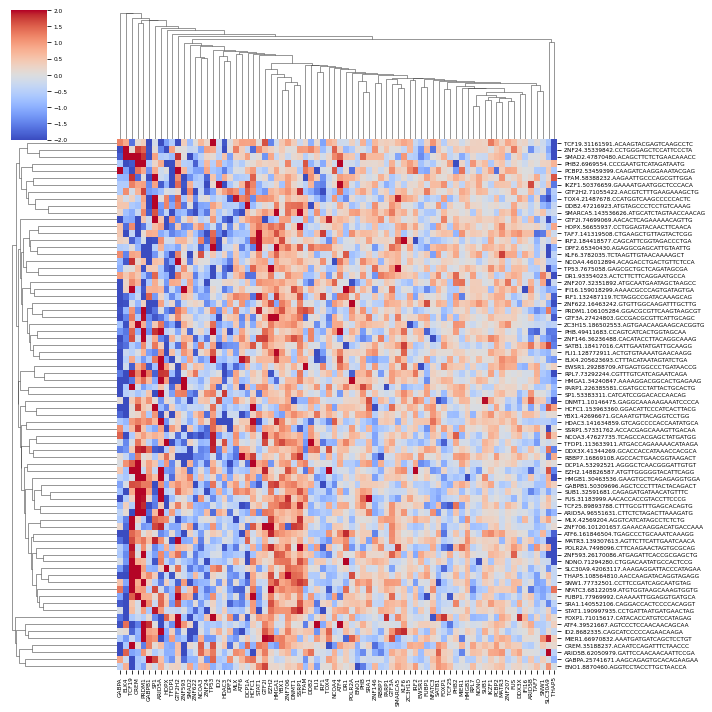

In [57]:
sns.clustermap(-1*heatmap, vmax=2, vmin=-2,xticklabels=1, yticklabels=1, center=0, cmap='coolwarm', z_score=0)

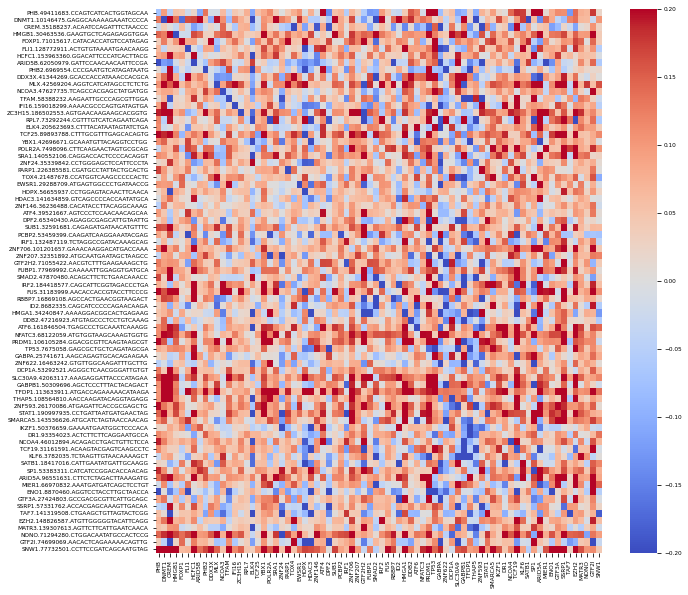

In [58]:
plt.figure(figsize=(10,10))
sns.heatmap(-1*heatmap, vmax=0.2, vmin=-0.2,xticklabels=1, yticklabels=1, center=0, cmap='coolwarm')
plt.savefig('targets.png', dpi=300)